In [1]:
import os

import torch

from bmadx.beam_generator import create_beam

from phase_space_reconstruction.virtual.beamlines import quad_scan_lattice
from phase_space_reconstruction.virtual.scans import run_quad_scan
from phase_space_reconstruction.diagnostics import ImageDiagnostic
from phase_space_reconstruction.train import train_quad_scan

from bmadx.plot import plot_projections
from phase_space_reconstruction.analysis import plot_scan_data, plot_predicted_screens

In [2]:
data_dir = 'data'

In [3]:
# load data:
train_dset = torch.load(os.path.join(data_dir,'train.dset'))
test_dset = torch.load(os.path.join(data_dir,'test.dset'))

# image bins: 
bins = torch.linspace(-30, 30, train_dset.images.shape[-1])*1e-3

image size = 60 x 60 mm
test samples boxed in orange


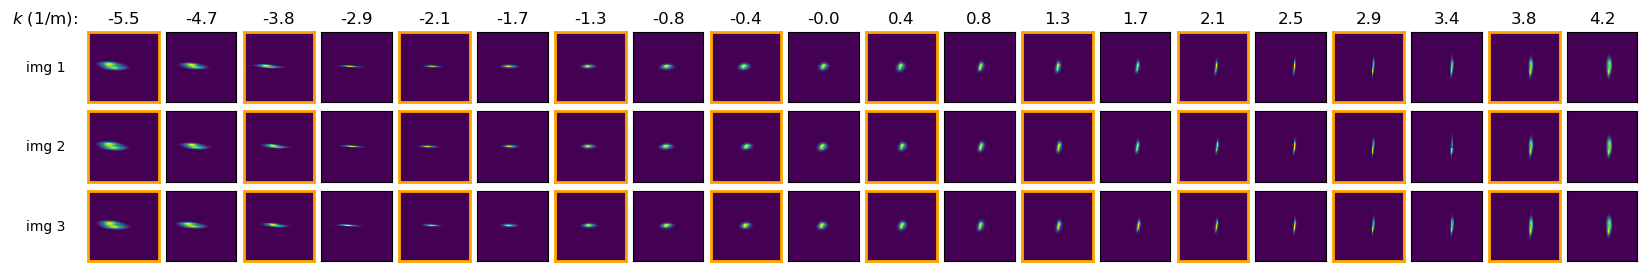

In [4]:
plot_scan_data(train_dset, test_dset, bins)

In [6]:
# diagnostic beamline:
lattice = quad_scan_lattice()

# diagnostic screen: 
bins = torch.linspace(-30, 30, 200) * 1e-3
bandwidth = (bins[1]-bins[0]) / 2
screen = ImageDiagnostic(bins, bandwidth)

In [8]:
# training
pred_beam = train_quad_scan(train_dset, lattice, screen, n_epochs=100, device='cuda')

Using device: cuda


type: 